# Data semantics

The project involves probing the subclass-of and instance-of ontological relations in masked language models. The ontology is used as a structured gold standard to construct negative and positive examples for the model.

The goal is therefore to evaluate whether and to what extent masked language models (such as BERT) encode ontological containment relations (is-a). This is done through probing experiments based on binary classification.

Objective is replicate result of following paper:
[Language Model Analysis for Ontology Subsumption Inference](https://arxiv.org/pdf/2302.06761)

## 0. Setup

In [1]:
!pip install -r requirements.txt

In [2]:
import torch
import math
from transformers import AutoTokenizer, AutoModelForMaskedLM
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch.nn as nn

/home/cava/Documents/Repos/Jupyter notebooks/data-semtics-project/data-semantics-project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load & Explore dataset

### 1.1. Load dataset

In [3]:
dataset = load_dataset("krr-oxford/OntoLAMA", "go-atomic-SI")

Small visualization to see dataset components:

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 772870
    })
    validation: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 96608
    })
    test: Dataset({
        features: ['v_sub_concept', 'v_super_concept', 'label', 'axiom'],
        num_rows: 96610
    })
})

### 1.2. Dataset exploration

In [5]:
for i in range(3):
    print(dataset['train'][i])

{'v_sub_concept': 'cytosolic lipolysis', 'v_super_concept': 'biological process', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_0061725> <http://purl.obolibrary.org/obo/GO_0008150>)'}
{'v_sub_concept': 'mitochondrial oxoglutarate dehydrogenase complex', 'v_super_concept': 'oxidoreductase complex', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_0009353> <http://purl.obolibrary.org/obo/GO_1990204>)'}
{'v_sub_concept': 'positive regulation of protein localization', 'v_super_concept': 'regulation of localization', 'label': 1, 'axiom': 'SubClassOf(<http://purl.obolibrary.org/obo/GO_1903829> <http://purl.obolibrary.org/obo/GO_0032879>)'}


We have a format like this:
- sub: specific concept

- sup: general concept

- label:

    - 1 → relazione is-a valida

    - 0 → relazione negativa

#### 1.2.1. Split into pd-dataframe

putting dataset of train test and val as pandas datasets (this makes it easier to analyze them)

In [6]:
df_train = pd.DataFrame(dataset['train'])
df_train

,v_sub_concept,v_super_concept,label,axiom
0,cytosolic lipolysis,biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,mitochondrial oxoglutarate dehydrogenase complex,oxidoreductase complex,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,positive regulation of protein localization,regulation of localization,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,hemicellulose catabolic process,biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,positive regulation of cell morphogenesis invo...,positive regulation of biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
772865,positive regulation of mitotic recombination-d...,positive regulation of meiosis i spindle assem...,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772866,aminolevulinate transaminase activity,aspartate-phenylpyruvate transaminase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772867,lung lobe formation,sno(s)rna metabolic process,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
772868,polysome binding,glycolate dehydrogenase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [7]:
df_test = pd.DataFrame(dataset['test'])
df_test

,v_sub_concept,v_super_concept,label,axiom
0,endonucleolytic cleavage of tricistronic rrna ...,cellular process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,"positive regulation of (z)-nonadeca-1,14-diene...",positive regulation of biosynthetic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,regulation of retrograde trans-synaptic signal...,regulation of biological process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,regulation of glutamine transport,regulation of anion transport,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,platelet-derived growth factor receptor-ligand...,membrane protein complex,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
96605,"regulation of complement activation, alternati...",regulation of melanization defense response,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96606,tubulin binding,fatz binding,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96607,coenzyme a metabolic process,signaling receptor complex adaptor activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96608,ecdysone 20-monooxygenase activity,methyl tertiary butyl ether 3-monooxygenase ac...,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [8]:
df_val = pd.DataFrame(dataset['validation'])
df_val

,v_sub_concept,v_super_concept,label,axiom
0,tryparedoxin peroxidase activity,molecular function,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
1,branched-chain amino acid catabolic process to...,branched-chain amino acid catabolic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
2,gerfelin catabolic process,cellular catabolic process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
3,vascular endothelial growth factor production,multicellular organismal process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
4,modification by virus of host cell cycle regul...,modulation by symbiont of host cellular process,1,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
...,...,...,...,...
96603,corticotropin hormone secreting cell development,oxazole or thiazole metabolic process,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96604,interferon-epsilon production,quercetin 3-o-methyltransferase activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96605,protein activation cascade,"mitochondrial electron transport, cytochrome c...",0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...
96606,homoserine transmembrane transporter activity,benzodiazepine receptor activity,0,SubClassOf(<http://purl.obolibrary.org/obo/GO_...


In [9]:
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

Train: (772870, 4)
Validation: (96608, 4)
Test: (96610, 4)


#### 1.2.2. Visulize labels distribution:

In [10]:
def label_stats(df):
    return df["label"].value_counts(normalize=True)

In [11]:
print("Train label distribution:\n", label_stats(df_train))
print()
print("Validation label distribution:\n", label_stats(df_val))
print()
print("Test label distribution:\n", label_stats(df_test))

Train label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


we have perfectly even distribution, wich is good (also same exact as the paper)

#### 1.2.3. Number of unique concepts

In [12]:
def unique_concepts(df):
    return {
        "unique_sub": df["v_sub_concept"].nunique(),
        "unique_sup": df["v_super_concept"].nunique()
    }

In [13]:
print("Number of unique concepts:")
print("Train:", unique_concepts(df_train))
print("Validation:", unique_concepts(df_val))
print("Test:", unique_concepts(df_test))

Number of unique concepts:
Train: {'unique_sub': 43303, 'unique_sup': 43171}
Validation: {'unique_sub': 36575, 'unique_sup': 27989}
Test: {'unique_sub': 36395, 'unique_sup': 27958}


overlap checking:

In [14]:
overlap = set(df_train["v_sub_concept"]).intersection(set(df_train["v_super_concept"]))
print(f"Number of overlapping concepts in train set: {len(overlap)} / {unique_concepts(df_train)['unique_sup']}")
print(f"Percentage of overlapping concepts in train set: {len(overlap) / unique_concepts(df_train)['unique_sup'] * 100:.2f}%")

Number of overlapping concepts in train set: 43171 / 43171
Percentage of overlapping concepts in train set: 100.00%


also if we check overlap of super-concept and sub-concept we have that 100% of super-concepts aligns with sub-concepts

**Although all concepts appear both as sub- and super-concepts, the task remains non-trivial, since labels are assigned to ordered concept pairs, forcing the model to reason about semantic containment rather than memorising individual concepts.**

In [15]:
df_train.groupby("v_sub_concept")["label"].nunique().value_counts()

label
2    43037
1      266
Name: count, dtype: int64

This demonstrates that for all sub-concepts exixst both positive and negative examples


#### 1.2.4. Number of words per token

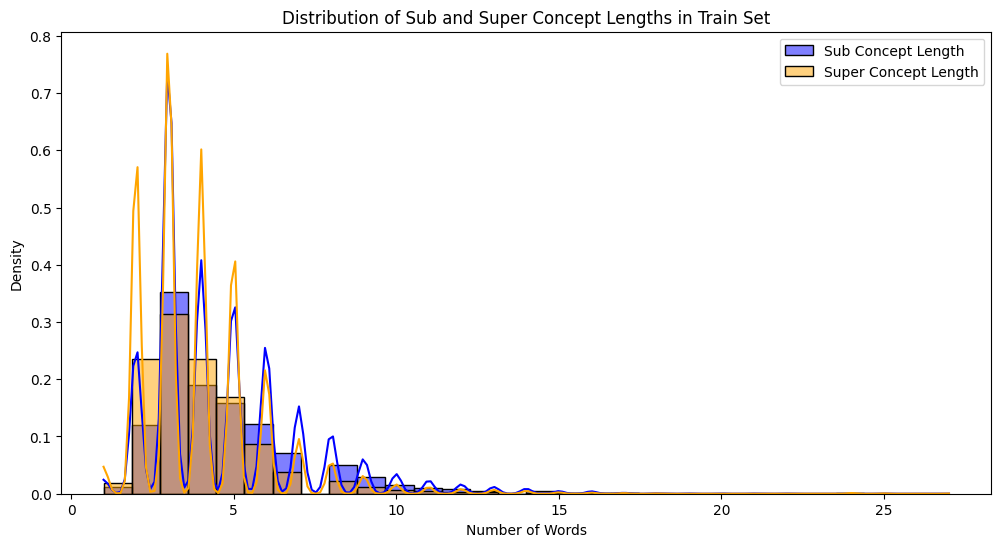

In [16]:
df_train["sub_len"] = df_train["v_sub_concept"].apply(lambda x: len(x.split()))
df_train["sup_len"] = df_train["v_super_concept"].apply(lambda x: len(x.split()))

df_train[["sub_len", "sup_len"]].describe()
plt.figure(figsize=(12, 6))
sns.histplot(df_train["sub_len"], color='blue', label='Sub Concept Length', kde=True, stat="density", bins=30)
sns.histplot(df_train["sup_len"], color='orange', label='Super Concept Length', kde=True, stat="density", bins=30)
plt.title('Distribution of Sub and Super Concept Lengths in Train Set')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.legend()
plt.show()

In [17]:
df_train[["sub_len", "sup_len"]].describe()

,sub_len,sup_len
count,772870.000000,772870.000000
mean,4.633279,3.960198
std,2.422115,2.031670
min,1.000000,1.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,6.000000,5.000000
max,27.000000,27.000000


here we can clearly see that most of tokens are made of 5 or less words (separated by space)

## 2. Creating prompt for model

### 2.1. Simplified propmpt

having prompt directly into dataset makes it easier for train aftewards:

In [18]:
def make_prompt(row):
    return f"{row['v_sub_concept']} is a [MASK] of {row['v_super_concept']}."

**IMPORTANT:**

here we differ from the original paper as the original paper had this type of prompt:
$$
\begin{aligned}
& T_1:=\underbrace{\text { It is <A> } \mathcal{V}(C)}_{\text {premise }} ?\text { <MASK> }, \underbrace{\text { it is <A> } \mathcal{V}(D)}_{\text {hypothesis }} . \\
& T_2:=\text { " } \underbrace{\text { It is <A> } \mathcal{V}(C)}_{\text {hypothesis }} \text { "? <MASK>, " } \underbrace{\text { it is <A> } \mathcal{V}(D)}_{\text {premise }} \text { ". } \\
& L_1:=\{\text { "positive": ["Yes"], "negative": ["No"] }\} \\
& L_2:=\{\text { "positive": ["Right"], "negative": ["Wrong"] }\} \\
& L_3:=\{\text { "positive": ["Yes", "Right"], }\text { "negative": ["No", "Wrong"] }\}
\end{aligned}
$$


Initially, we experimented with simplified templates:

$$\text{<C> is a [MASK] of <D>}$$

This is done because the new prompt and the paper prompt syntactically mean the same thing and **out hypotesis** is that those two different prompts lead to the same result. For faithful replication of the original work, we then adopt the NLI-style templates and label sets proposed in the paper for both zero-shot and K-shot settings.

In [19]:
df_train["prompt_simplified"] = df_train.apply(make_prompt, axis=1)
df_train[["prompt_simplified", "label"]].head()

,prompt_simplified,label
0,cytosolic lipolysis is a [MASK] of biological ...,1
1,mitochondrial oxoglutarate dehydrogenase compl...,1
2,positive regulation of protein localization is...,1
3,hemicellulose catabolic process is a [MASK] of...,1
4,positive regulation of cell morphogenesis invo...,1


Then we repeat the process for all remaining datasets:

In [20]:
df_test["prompt_simplified"] = df_test.apply(make_prompt, axis=1)
df_val["prompt_simplified"] = df_val.apply(make_prompt, axis=1)

### 2.2. Paper equivalent prompt:

**IMPORTANT:**

For this experiment we only use one prompt, instead of 2 (like in the actual paper) as both prompts closely resembles eachother and 

In [21]:
def verbalize(concept):
    return concept.replace("_", " ")

def template_T1(C, D):
    return f"It is a {verbalize(C)}? [MASK], it is a {verbalize(D)}."

For each experiment, we construct a single prompt per input instance by applying one template 
$T_i$ at a time. Different templates and label sets are evaluated independently, following the experimental protocol of the original paper.

In [22]:
def make_prompt_templates(row, template_func):
    return template_func(row['v_sub_concept'], row['v_super_concept'])

df_train["prompt"] = df_train.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_test["prompt"] = df_test.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_val["prompt"] = df_val.apply(lambda row: make_prompt_templates(row, template_T1), axis=1)
df_train[["prompt", "label"]].head()

,prompt,label
0,"It is a cytosolic lipolysis? [MASK], it is a b...",1
1,It is a mitochondrial oxoglutarate dehydrogena...,1
2,It is a positive regulation of protein localiz...,1
3,It is a hemicellulose catabolic process? [MASK...,1
4,It is a positive regulation of cell morphogene...,1


## 3. Baseline probe with Bert (0-shot)

prompt → MLM (frozen) → logits → verbalizer manuale → label

### 3.1. Load first model: no fine tuning (baseline)

for our first model we try using an instance of pre-trained bert so. Wich means we try and replicate the 0-shot results from the papers


In [23]:
model_name = "bert-base-uncased"

In [24]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

model.eval()  # IMPORTANTISSIMO: modalità inference

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [25]:
example = df_train.iloc[0]["prompt_simplified"]

inputs = tokenizer(
    example,
    return_tensors="pt"
)

inputs

{'input_ids': tensor([[  101, 22330, 13122, 23518,  5423,  4747, 20960,  2003,  1037,   103,
          1997,  6897,  2832,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

After tokenization we can see 103 is [MASK] for BERT. Then we need to find mask index for model

In [26]:
mask_token_id = tokenizer.mask_token_id
mask_index = (inputs["input_ids"] == mask_token_id).nonzero(as_tuple=True)[1]

mask_index

tensor([9])

### 3.2 Classification with Bert (simplified prompt):

First we define a verbalizer baseline:

In [27]:
positive_words = [
    "kind", "type", "category", "class", "group", "form", "sort", "example", "instance", "subclass", "species", "variety", "family", "genus"
]
negative_words = [
    "part", "member", "component", "piece", "element", "section", "fragment", "portion", "aspect", "feature", "attribute", "property", "role"
]

pos_ids = tokenizer.convert_tokens_to_ids(positive_words)
neg_ids = tokenizer.convert_tokens_to_ids(negative_words)

In [28]:
def predict_is_a_batch(prompts, batch_size=16):
    preds = []

    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        )

        mask_indices = (inputs["input_ids"] == tokenizer.mask_token_id)

        with torch.no_grad():
            logits = model(**inputs).logits

        for j in range(len(batch)):
            mask_idx = mask_indices[j].nonzero(as_tuple=True)[0].item()
            mask_logits = logits[j, mask_idx]

            pos_score = mask_logits[pos_ids].mean().item()
            neg_score = mask_logits[neg_ids].mean().item()

            preds.append(int(pos_score > neg_score))

    return preds


In the initial experiments, we adopt a simple manually defined verbalizer that maps the masked-token predictions to binary labels. This serves as a zero-shot probing baseline, before introducing trainable probes as in prior work.

We'll make predictions only on random 2000 samples as doing the whole 96k test set would take a muchh longer time.

In [29]:
number_of_samples = 3000 # or whatever you want

In [30]:
df_test_sample = df_test.sample(n=number_of_samples, random_state=42)

df_test_sample["pred_simplified"] = predict_is_a_batch(
    df_test_sample["prompt_simplified"].tolist(),
    batch_size=32
)

**Evaluation:**

In [31]:
y_true = df_test_sample["label"]
y_pred = df_test_sample["pred_simplified"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))


Accuracy: 0.65
F1: 0.662379421221865
Precision: 0.64576802507837
Recall: 0.6798679867986799


as we can see the results closely resembles the ones obtained in the paper with 0-shot:
![image_1.png](image_1.png)

Actually we are getting better results! this is  the fact we are not directly using 'Roberta model' but 'bert-base-uncased model' wich is probably fitter to this task AND the fact that our prompt is slightly different, making it easier for the model to predict the right word.

This means we are one step closer to achieving the same results overall

### 3.3. Classification with Bert (paper equivalent prompt):

then we use this verbalizer: 
$$
\sum_{v \in L_j[y]} \exp \left(\mathbf{w}_v \cdot \mathbf{h}_{M A S K}\right)
$$

In the zero-shot setting, since the denominator of the label-word softmax is identical across classes, we directly compare the unnormalised scores, which is equivalent for argmax prediction.

In [32]:
LABEL_SETS = {
    "L1": {"positive": ["yes"], "negative": ["no"]},
    "L2": {"positive": ["right"], "negative": ["wrong"]},
    "L3": {"positive": ["yes", "right"], "negative": ["no", "wrong"]}
}

of those we will only use L3 as it is the most general

In [33]:
def predict_zero_shot(prompt, label_set):
    inputs = tokenizer(prompt, return_tensors="pt")
    mask_idx = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    with torch.no_grad():
        logits = model(**inputs).logits

    mask_logits = logits[0, mask_idx].squeeze(0)

    scores = {}
    for cls in ["positive", "negative"]:
        token_ids = tokenizer.convert_tokens_to_ids(label_set[cls])
        scores[cls] = torch.logsumexp(mask_logits[token_ids], dim=0)

    return int(scores["positive"] > scores["negative"])

then we do prediction using the base model (still using only a limited number of samples as the whole dataset would take too much time):

In [34]:
df_test_sample_2 = df_test.sample(n=number_of_samples, random_state=42)

In [35]:
df_test_sample_2["pred"] = df_test_sample_2["prompt"].apply(
    lambda p: predict_zero_shot(p, LABEL_SETS["L3"])
)

**Evaluation:**

In [36]:
y_true = df_test_sample_2["label"]
y_pred = df_test_sample_2["pred"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))

Accuracy: 0.4696666666666667
F1: 0.6211002619671351
Precision: 0.4858420268256334
Recall: 0.8607260726072608


As we can see the results are almost identical to the ones obtained in the paper with 0-shot:
![image_1.png](image_1.png)

This proves to us that **our custom prompt** is actually a bit better to help classify this problem!


## 4. Probe with Bert (4-shot)

The K-shot setting refers to training a lightweight probe on top of frozen language models using K labeled examples per class, enabling the evaluation of how quickly ontological knowledge can be elicited from pre-trained representations.

prompt → MLM (frozen) → h_MASK → trainable classifier → label

first we define the k-shot function:

In [37]:
def sample_k_shot(df, k, seed):
    return (
        df.groupby("label", group_keys=False)
          .apply(lambda x: x.sample(n=k, random_state=seed))
          .reset_index(drop=True)
    )

In [38]:
K = 4
seed = 42

This means we'll use:
- 4 positive examples
- 4 negative examples

in order to train a small classifier (probe) to add to the bert model prediction (we try improve previous performance using probing)

In [39]:
df_train_4 = sample_k_shot(df_train, K, seed)
df_val_4   = sample_k_shot(df_val, K, seed)

/tmp/ipykernel_24286/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))
/tmp/ipykernel_24286/1800851864.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=k, random_state=seed))


In [40]:
model = AutoModelForMaskedLM.from_pretrained(
    model_name,
    output_hidden_states=True
)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

### 4.1. Probing on simplified prompt

### 4.2. Probing on papers prompt

#### 4.2.1. Preparing the training

In [41]:
def get_mask_embedding(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    mask_idx = (inputs["input_ids"] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

    with torch.no_grad():
        outputs = model(**inputs)

    # ultimo layer, token [MASK]
    h_mask = outputs.hidden_states[-1][0, mask_idx]
    return h_mask.squeeze(0)  # shape: (hidden_size,)


In [42]:
X_train = torch.stack(df_train_4["prompt"].apply(get_mask_embedding).tolist())
y_train = torch.tensor(df_train_4["label"].values)

X_val = torch.stack(df_val_4["prompt"].apply(get_mask_embedding).tolist())
y_val = torch.tensor(df_val_4["label"].values)

In [43]:
probe = nn.Linear(X_train.shape[1], 2)

#### 4.2.2. Training

In [44]:
optimizer = torch.optim.AdamW(probe.parameters())
loss_fn = nn.CrossEntropyLoss()

best_val_acc = 0.0
best_probe_state = None

for epoch in range(10):
    # TRAIN
    probe.train()
    optimizer.zero_grad()
    logits = probe(X_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()

    # VALIDATION
    probe.eval()
    with torch.no_grad():
        val_logits = probe(X_val)
        val_preds = val_logits.argmax(dim=1)
        val_acc = (val_preds == y_val).float().mean().item()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_probe_state = probe.state_dict()

In [45]:
probe.load_state_dict(best_probe_state)

<All keys matched successfully>

#### 4.2.3. Inference + evaluation

In [46]:
def predict_4_shot(prompt):
    h = get_mask_embedding(prompt)
    with torch.no_grad():
        logits = probe(h)
    return logits.argmax().item()

In [47]:
df_test_sample_2["pred"] = df_test_sample_2["prompt"].apply(predict_4_shot)

In [48]:
print("Accuracy:", accuracy_score(df_test_sample_2["label"], df_test_sample_2["pred"]))
print("F1:", f1_score(df_test_sample_2["label"], df_test_sample_2["pred"]))
print("Precision:", precision_score(df_test_sample_2["label"], df_test_sample_2["pred"]))
print("Recall:", recall_score(df_test_sample_2["label"], df_test_sample_2["pred"]))

Accuracy: 0.6236666666666667
F1: 0.5242309313105773
Precision: 0.7249417249417249
Recall: 0.41056105610561056


Once again we perfectly re-create the same exact result as on the refence paper:

![image_2.png](image_2.png)